# Inciso 3

In [20]:
import json, re, string
from pathlib import Path
from typing import List, Dict, Any, Iterable, Optional

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import networkx as nx
import numpy as np

In [ ]:
# Carga de tweets 
def cargar_tweets_jsonl(ruta):
    """
    Lee JSONL o una lista JSON desde un archivo que puede estar en UTF-8 o UTF-16.
    Devuelve: lista de dicts (uno por tweet).
    """
    raw = Path(ruta).read_bytes()

    # Detectar UTF-16 por BOM
    if raw.startswith(b'\xff\xfe') or raw.startswith(b'\xfe\xff'):
        texto = raw.decode('utf-16')
    else:
        # utf-8 "normal"; si hubiera BOM utf-8, decode lo maneja.
        texto = raw.decode('utf-8', errors='strict')

    texto = texto.strip()
    tweets = []

    # Intento 1: JSON Lines (una línea por objeto)
    ok = 0
    for linea in texto.splitlines():
        linea = linea.strip()
        if not linea:
            continue
        try:
            tweets.append(json.loads(linea))
            ok += 1
        except json.JSONDecodeError:
            pass
    if ok > 0:
        return tweets

    # Intento 2: JSON como lista
    data = json.loads(texto)
    if isinstance(data, list):
        return data

    raise ValueError("El archivo no es JSONL ni lista JSON válida.")

# Normalización de usuarios
def normalizar_usuario(u: Optional[str]) -> Optional[str]:
    """
    Normaliza nombres de usuario:
    - minúsculas, quita espacios
    - quita '@' al inicio si existe
    """
    if u is None:
        return None
    u = str(u).strip().lower()
    if u.startswith("@"):
        u = u[1:]
    return u or None

In [ ]:
# Preprocesamiento de texto (inciso 3.1)

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def _asegurar_recursos_nltk():
    try:
        _ = stopwords.words("english")
    except LookupError:
        nltk.download("stopwords")
    try:
        nltk.download("wordnet"); nltk.download("omw-1.4")
    except Exception:
        pass

_asegurar_recursos_nltk()
STOP_EN = set(stopwords.words("english"))
# Conservar negaciones (suelen aportar señal)
for w in ["no", "not", "nor", "n't"]:
    STOP_EN.discard(w)
lematizador = WordNetLemmatizer()

RE_URL        = re.compile(r"https?://\S+|www\.\S+")
RE_MENCION    = re.compile(r"@\w+")
RE_HASHTAG    = re.compile(r"#")                 # quitamos solo el símbolo '#'
RE_APOSTROFES = re.compile(r"[’‘´`']")
RE_EMOTICONES = re.compile(r"(:\)|:-\)|:\(|:-\(|;-\)|;\)|:D|:-D|:\||:-\||:\]|:\[|:P|:-P|<3)")
RE_EMOJIS     = re.compile("["                   # rangos Unicode comunes
                           "\U0001F1E0-\U0001F1FF"
                           "\U0001F300-\U0001F5FF"
                           "\U0001F600-\U0001F64F"
                           "\U0001F680-\U0001F6FF"
                           "\U0001F700-\U0001F77F"
                           "\U0001F780-\U0001F7FF"
                           "\U0001F800-\U0001F8FF"
                           "\U0001F900-\U0001F9FF"
                           "\U0001FA00-\U0001FA6F"
                           "\U00002700-\U000027BF"
                           "]+", flags=re.UNICODE)
RE_NO_ALFANUM = re.compile(r"[^a-z0-9\s]")

def preprocesar_texto(texto: str,
                      minusculas: bool = True,
                      quitar_urls: bool = True,
                      quitar_menciones: bool = True,
                      quitar_simbolo_hashtag: bool = True,
                      quitar_emoticones_emojis: bool = True,
                      quitar_puntuacion: bool = True,
                      quitar_numeros: bool = True,
                      conservar_911: bool = True,
                      quitar_stopwords: bool = True,
                      lematizar: bool = False) -> str:
    """Limpieza solicitada en 3.1 del laboratorio."""
    if not isinstance(texto, str):
        texto = str(texto)

    if minusculas:
        texto = texto.lower()
    if quitar_urls:
        texto = RE_URL.sub(" ", texto)
    if quitar_menciones:
        texto = RE_MENCION.sub(" ", texto)
    if quitar_simbolo_hashtag:
        texto = RE_HASHTAG.sub("", texto)

    texto = RE_APOSTROFES.sub("", texto)

    if quitar_emoticones_emojis:
        texto = RE_EMOTICONES.sub(" ", texto)
        texto = RE_EMOJIS.sub(" ", texto)

    if quitar_puntuacion:
        texto = texto.translate(str.maketrans('', '', string.punctuation))
        texto = RE_NO_ALFANUM.sub(" ", texto)

    if quitar_numeros:
        if conservar_911:
            texto = re.sub(r"\b911\b", " keepnineoneone ", texto)
        texto = re.sub(r"\d+", " ", texto)
        if conservar_911:
            texto = texto.replace("keepnineoneone", "911")

    tokens = [t for t in texto.split() if t]
    if quitar_stopwords:
        tokens = [t for t in tokens if t not in STOP_EN]
    if lematizar:
        tokens = [lematizador.lemmatize(t) for t in tokens]

    return " ".join(tokens)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jemil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jemil\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Extracción de campos clave desde el JSON (inciso 3.2)
def extraer_campos_tweet(t: dict) -> dict:
    user = t.get("user") or {}
    autor = user.get("username") or user.get("screen_name")
    texto = (t.get("rawContent") or t.get("content") or
             t.get("full_text") or t.get("text") or "")

    # Menciones
    mencs = []
    if isinstance(t.get("mentionedUsers"), list):
        mencs = [x.get("username") for x in t["mentionedUsers"] if isinstance(x, dict)]
    elif isinstance(t.get("entities"), dict):
        um = t["entities"].get("user_mentions") or []
        mencs = [x.get("screen_name") for x in um if isinstance(x, dict)]

    # Respuestas
    reply_to_user = None
    ruser = t.get("inReplyToUser")
    if isinstance(ruser, dict):
        reply_to_user = ruser.get("username") or ruser.get("screen_name")
    # Si solo viene el tweet id de respuesta, no es trivial recuperar el usuario sin más datos.

    # Retweet
    retweeted_user = None
    if isinstance(t.get("retweetedTweet"), dict):
        ru = t["retweetedTweet"].get("user") or {}
        retweeted_user = ru.get("username") or ru.get("screen_name")

    # Cita
    quoted_user = None
    if isinstance(t.get("quotedTweet"), dict):
        qu = t["quotedTweet"].get("user") or {}
        quoted_user = qu.get("username") or qu.get("screen_name")

    # Métricas
    retweets = t.get("retweetCount")
    likes    = t.get("likeCount")
    replies  = t.get("replyCount")
    quotes   = t.get("quoteCount")

    # Hashtags (si vienen)
    hashtags = []
    if isinstance(t.get("hashtags"), list):
        hashtags = [h if isinstance(h, str) else h.get("text") for h in t["hashtags"]]
    elif isinstance(t.get("entities"), dict):
        hs = t["entities"].get("hashtags") or []
        hashtags = [h.get("text") for h in hs if isinstance(h, dict)]

    return {
        "id_tweet": t.get("id_str") or t.get("id"),
        "fecha": t.get("date") or t.get("created_at"),
        "autor": normalizar_usuario(autor),
        "texto": texto,
        "texto_limpio": preprocesar_texto(texto),
        "menciones": [normalizar_usuario(u) for u in mencs if u],
        "responde_a": normalizar_usuario(reply_to_user),
        "retuitea_a": normalizar_usuario(retweeted_user),
        "cita_a": normalizar_usuario(quoted_user),
        "retweets": retweets, "likes": likes, "replies": replies, "quotes": quotes,
        "hashtags": [str(h).lower() for h in hashtags if h],
        "origen_json": t  # opcional: referencia al original por si hace falta
    }


In [ ]:
# Limpieza de duplicados y normalización (inciso 3.3)
def limpiar_y_normalizar(df_tweets: pd.DataFrame) -> pd.DataFrame:
    df = df_tweets.copy()
    df = df.drop_duplicates(subset=["id_tweet"])
    # ya normalizamos autor/menciones en extraer_campos_tweet pero reforzamos por si hubo nulos/espacios
    df["autor"] = df["autor"].apply(normalizar_usuario)
    df["menciones"] = df["menciones"].apply(lambda xs: sorted({normalizar_usuario(x) for x in xs if x}))
    # convierte fecha a datetime si es posible
    df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
    return df


In [ ]:
# Estructura de red: aristas dirigidas (inciso 3.4)
#    tipos: mencion, respuesta, retweet, cita
def crear_aristas_desde_tweets(df: pd.DataFrame) -> pd.DataFrame:
    filas = []
    for _, r in df.iterrows():
        autor = r["autor"]
        if not autor:
            continue
        # menciones (autor -> mencionado)
        for m in r["menciones"]:
            if m and m != autor:
                filas.append({"origen": autor, "destino": m, "tipo": "mencion",
                              "tweet_id": r["id_tweet"], "fecha": r["fecha"]})
        # respuesta (autor -> usuario respondido)
        if pd.notna(r.get("responde_a")) and r["responde_a"] and r["responde_a"] != autor:
            filas.append({"origen": autor, "destino": r["responde_a"], "tipo": "respuesta",
                          "tweet_id": r["id_tweet"], "fecha": r["fecha"]})
        # retweet (autor -> autor original)
        if pd.notna(r.get("retuitea_a")) and r["retuitea_a"] and r["retuitea_a"] != autor:
            filas.append({"origen": autor, "destino": r["retuitea_a"], "tipo": "retweet",
                          "tweet_id": r["id_tweet"], "fecha": r["fecha"]})
        # cita (autor -> autor citado)
        if pd.notna(r.get("cita_a")) and r["cita_a"] and r["cita_a"] != autor:
            filas.append({"origen": autor, "destino": r["cita_a"], "tipo": "cita",
                          "tweet_id": r["id_tweet"], "fecha": r["fecha"]})
    aristas = pd.DataFrame(filas)
    if not aristas.empty:
        aristas = aristas.drop_duplicates()
    return aristas


In [ ]:
# Pipeline práctico para el inciso 3
#   devuelve: df_tweets (campos planos + texto_limpio), df_aristas (origen, destino, tipo, tweet_id, fecha)
def preparar_datos_para_red(ruta_txt: str | Path) -> tuple[pd.DataFrame, pd.DataFrame]:

    tweets_raw = cargar_tweets_jsonl(ruta_txt)
    registros = [extraer_campos_tweet(t) for t in tweets_raw]
    df_tweets = pd.DataFrame(registros)
    df_tweets = limpiar_y_normalizar(df_tweets)
    df_aristas = crear_aristas_desde_tweets(df_tweets)
    return df_tweets, df_aristas

In [8]:
RUTA = "tioberny.txt"   
df_tweets, df_aristas = preparar_datos_para_red(RUTA)
print(df_tweets.head(3))
print(df_aristas.head(10))
print("Tweets únicos:", len(df_tweets), "   Aristas:", len(df_aristas))
print("Tipos de interacciones:\n", df_aristas['tipo'].value_counts())

              id_tweet                     fecha           autor  \
0  1834281080029110288 2024-09-12 17:21:03+00:00  la_revoluzzion   
1  1834252464092069901 2024-09-12 15:27:20+00:00      xelanewsgt   
2  1834280919336976681 2024-09-12 17:20:25+00:00       m24095273   

                                               texto  \
0  _\nConfirmado Compañeres,\n\nEl impuesto por l...   
1  #URGENTE Lo que los medios #faferos no informa...   
2  @IvanDuque @BArevalodeLeon Con que usaste PEGA...   

                                        texto_limpio  \
0  confirmado compa eres el impuesto por la solo ...   
1  urgente lo que los medios faferos no informaro...   
2  con que usaste pegasus para espiar tus detract...   

                                           menciones responde_a retuitea_a  \
0  [48cantonestoto, barevalodeleon, ueguatemala, ...       None       None   
1                                                 []       None       None   
2                        [barevalodeleon, i

# Inciso 4

In [11]:
def top_serie(serie, k=20):
    return serie.value_counts().head(k)

def a_lista_hashtags(col):
    # col es una Serie de listas; convierte a una lista larga
    bolsa = []
    for x in col.fillna([]):
        if isinstance(x, list):
            bolsa.extend([str(h).lower() for h in x if h])
    return bolsa

# 4.1.a Resumen básico
def resumen_basico(df_tweets: pd.DataFrame, df_aristas: pd.DataFrame) -> pd.DataFrame:
    n_tweets = len(df_tweets)
    n_usuarios = df_tweets['autor'].nunique(dropna=True)

    n_menciones = df_aristas.query("tipo == 'mencion'").shape[0]
    n_respuestas = df_aristas.query("tipo == 'respuesta'").shape[0]
    n_retweets  = df_aristas.query("tipo == 'retweet'").shape[0]
    n_citas     = df_aristas.query("tipo == 'cita'").shape[0]

    prom_menciones_por_tweet = (n_menciones / n_tweets) if n_tweets else 0

    filas = [
        ("tweets", n_tweets),
        ("usuarios_unicos", n_usuarios),
        ("menciones", n_menciones),
        ("respuestas", n_respuestas),
        ("retweets", n_retweets),
        ("citas", n_citas),
        ("prom_menciones_por_tweet", round(prom_menciones_por_tweet, 3)),
    ]
    return pd.DataFrame(filas, columns=["métrica", "valor"])

# 4.1.b Rankings de interacción
def ranking_usuarios_que_mencionan(df_aristas, k=20):
    m = df_aristas.query("tipo == 'mencion'")
    return top_serie(m['origen'], k)

def ranking_usuarios_mencionados(df_aristas, k=20):
    m = df_aristas.query("tipo == 'mencion'")
    return top_serie(m['destino'], k)

def ranking_usuarios_respondidos(df_aristas, k=20):
    r = df_aristas.query("tipo == 'respuesta'")
    return top_serie(r['destino'], k)

# 4.1.c Hashtags frecuentes
import pandas as pd

def hashtags_frecuentes(df_tweets: pd.DataFrame, k: int = 20) -> pd.Series:
    if 'hashtags' not in df_tweets.columns:
        return pd.Series([], dtype=int)

    # Normaliza cada celda a lista; si no es lista, la volvemos lista vacía
    s = df_tweets['hashtags'].apply(
        lambda xs: [str(h).lower() for h in xs] if isinstance(xs, list) else []
    )

    # Convierte "lista por fila" en una sola columna con un hashtag por fila
    s = s.explode()

    # Quita NaN y cuenta
    s = s.dropna()
    return s.value_counts().head(k)


# 4.1.d Nube de palabras
def nube_palabras_texto_limpio(df_tweets, titulo='WordCloud — texto limpio', guardar=None):
    corpus = " ".join(df_tweets['texto_limpio'].dropna().astype(str).tolist())
    wc = WordCloud(width=1000, height=500, background_color='white', collocations=False)
    img = wc.generate(corpus)
    plt.figure(figsize=(10,5))
    plt.imshow(img, interpolation='bilinear'); plt.axis('off'); plt.title(titulo)
    if guardar:
        wc.to_file(guardar)
    plt.show()

#4.1.e Gráficos de barras helper
def graficar_barras(serie, titulo):
    plt.figure(figsize=(8,4))
    serie.plot(kind='bar')
    plt.title(titulo); plt.ylabel('frecuencia')
    plt.xticks(rotation=70, ha='right'); plt.tight_layout()
    plt.show()


                    métrica      valor
0                    tweets   4944.000
1           usuarios_unicos   2620.000
2                 menciones  17066.000
3                respuestas   4291.000
4                  retweets      0.000
5                     citas    276.000
6  prom_menciones_por_tweet      3.452


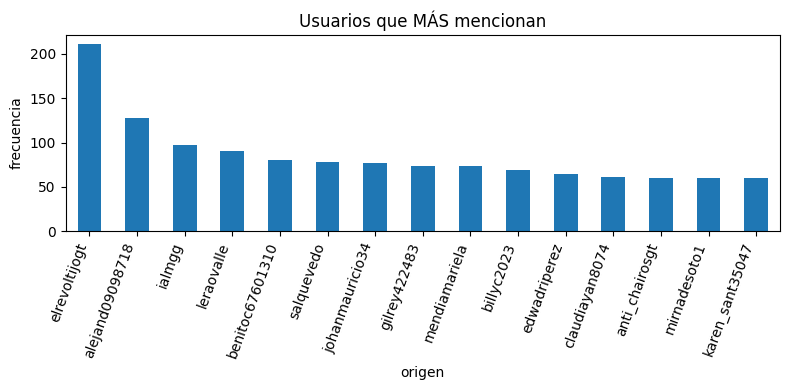

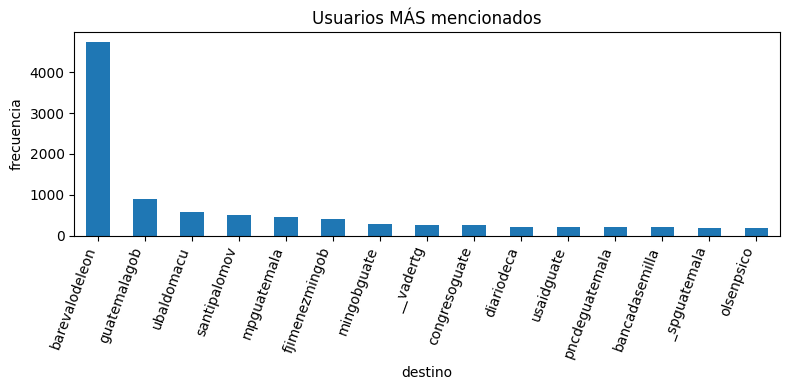

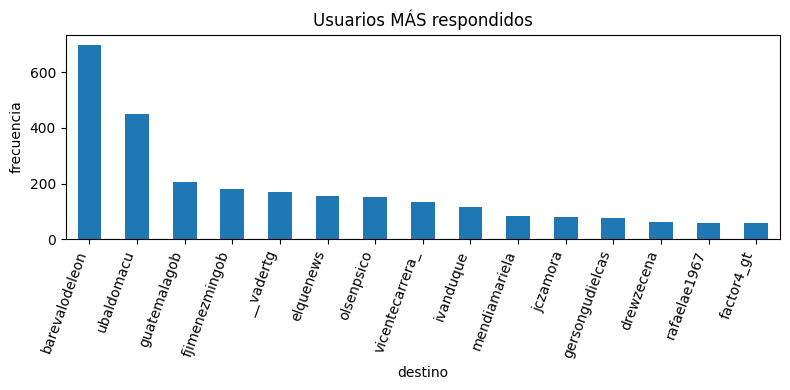

C:\Users\jemil\AppData\Local\Temp\ipykernel_20936\442266895.py:84: UserWarning: Glyph 26410 (\N{CJK UNIFIED IDEOGRAPH-672A}) missing from font(s) DejaVu Sans.
  plt.xticks(rotation=70, ha='right'); plt.tight_layout()
C:\Users\jemil\AppData\Local\Temp\ipykernel_20936\442266895.py:84: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) DejaVu Sans.
  plt.xticks(rotation=70, ha='right'); plt.tight_layout()
C:\Users\jemil\AppData\Local\Temp\ipykernel_20936\442266895.py:84: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  plt.xticks(rotation=70, ha='right'); plt.tight_layout()
C:\Users\jemil\AppData\Local\Temp\ipykernel_20936\442266895.py:84: UserWarning: Glyph 32773 (\N{CJK UNIFIED IDEOGRAPH-8005}) missing from font(s) DejaVu Sans.
  plt.xticks(rotation=70, ha='right'); plt.tight_layout()
C:\Users\jemil\AppData\Local\Temp\ipykernel_20936\442266895.py:84: UserWarning: Glyph 30053 (\N{CJK UNIFIED IDEOGRAPH-7565}) missing

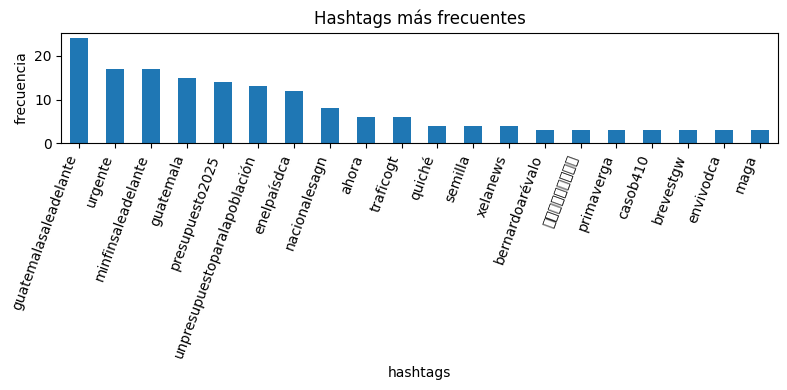

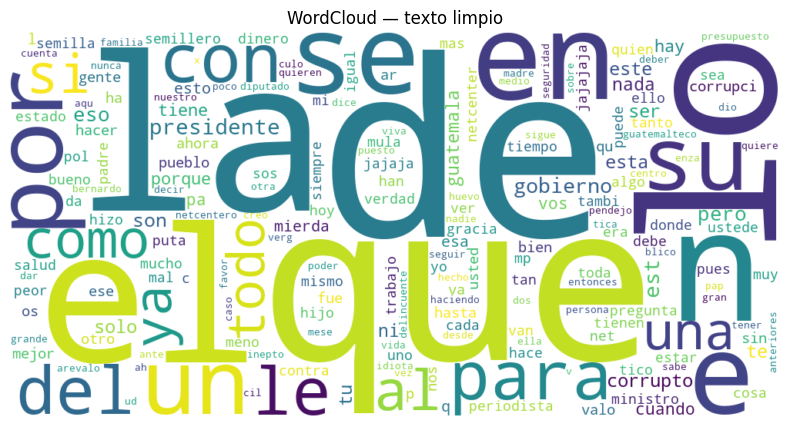

In [12]:
# 1) Resumen
resumen = resumen_basico(df_tweets, df_aristas)
print(resumen)

# 2) Rankings
top_mencionan   = ranking_usuarios_que_mencionan(df_aristas, k=15)
top_mencionados = ranking_usuarios_mencionados(df_aristas, k=15)
top_respondidos = ranking_usuarios_respondidos(df_aristas, k=15)

graficar_barras(top_mencionan,   'Usuarios que MÁS mencionan')
graficar_barras(top_mencionados, 'Usuarios MÁS mencionados')
graficar_barras(top_respondidos, 'Usuarios MÁS respondidos')

# 3) Hashtags
top_hash = hashtags_frecuentes(df_tweets, k=20)
graficar_barras(top_hash, 'Hashtags más frecuentes')

# 4) Nube de palabras (con texto limpio)
nube_palabras_texto_limpio(df_tweets, guardar='wordcloud_barevalo.png')


¿Quiénes son los 10 usuarios que más mencionan a @BArevalodeLeon?

In [ ]:
OBJ = 'barevalodeleon'  # normalizado en minúsculas

m = df_aristas.query("tipo=='mencion' and destino == @OBJ")
top_quienes_mencionan_a_BA = m['origen'].value_counts().head(10)
print(top_quienes_mencionan_a_BA)


origen
elrevoltijogt      40
benitoc67601310    31
ialmgg             21
minfingt           20
dupin07            18
vvj_gt             18
dimb502            16
anti_chairosgt     16
spaceboy88fly      16
diariodeca         15
Name: count, dtype: int64


¿Quiénes son los 10 usuarios que más mencionan a @BArevalodeLeon?

tipo
mencion      0.789
respuesta    0.198
cita         0.013
Name: proportion, dtype: float64


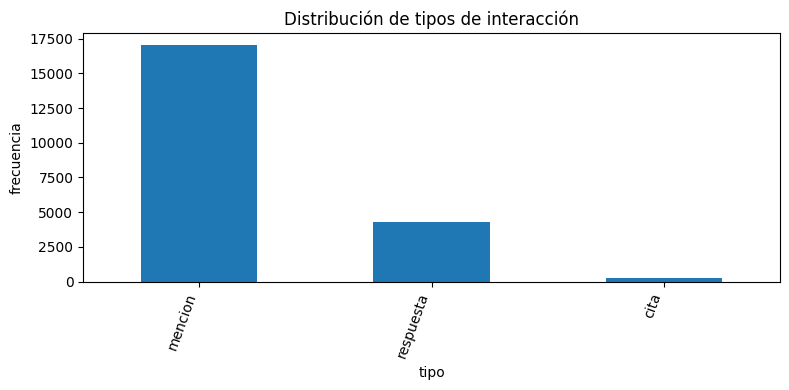

In [ ]:
mix = df_aristas['tipo'].value_counts(normalize=True).round(3)
print(mix)  # proporciones
graficar_barras(df_aristas['tipo'].value_counts(), 'Distribución de tipos de interacción')


¿Cuáles son los 20 hashtags más asociados a tweets que mencionan a @BArevalodeLeon?

In [ ]:
OBJ = 'barevalodeleon'   # o '@BArevalodeLeon' → lo limpio abajo si quieres

# 1) IDs de tweets que MENCIONAN a @BArevalodeLeon (según df_aristas)
mask = (df_aristas['tipo'] == 'mencion') & (df_aristas['destino'] == OBJ)
ids_mencionan_BA = set(df_aristas.loc[mask, 'tweet_id'].astype(str))

# 2) Hashtags de esos tweets (desde df_tweets → columna 'hashtags' que es lista)
top_hash = (
    df_tweets.loc[df_tweets['id_tweet'].astype(str).isin(ids_mencionan_BA), 'hashtags']
        .apply(lambda xs: xs if isinstance(xs, list) else [])  # asegura lista
        .explode()                                            # un hashtag por fila
        .dropna()
        .astype(str).str.lower()
        .value_counts()
        .head(20)
)

print(top_hash)


hashtags
guatemalasaleadelante           22
minfinsaleadelante              17
unpresupuestoparalapoblación    13
presupuesto2025                 13
enelpaísdca                     12
guatemala                        9
nacionalesagn                    8
urgente                          5
quiché                           4
semilla                          4
primaverga                       3
未成年者略取誘拐罪                        3
ahora                            3
envivodca                        3
conadur                          3
miguelmartinez                   3
golpedeestado                    3
tiktok                           3
maga                             3
brevestgw                        3
Name: count, dtype: int64


# Inciso 5

5.1 

In [ ]:
def construir_grafo_dirigido(df_aristas: pd.DataFrame,
                             tipos: Optional[Iterable[str]] = None,
                             quitar_autolazos: bool = True) -> nx.DiGraph:
    G = nx.DiGraph()
    data = df_aristas.copy()
    if tipos:
        data = data[data['tipo'].isin(tipos)]
    for _, r in data.iterrows():
        u, v = r['origen'], r['destino']
        if not u or not v:
            continue
        if quitar_autolazos and u == v:
            continue
        # acumulamos peso por si hay varias interacciones iguales
        if G.has_edge(u, v):
            G[u][v]['peso'] += 1
        else:
            G.add_edge(u, v, peso=1, tipo=r['tipo'], tweet_id=r['tweet_id'], fecha=r['fecha'])
    return G

def rankings_basicos(G: nx.DiGraph, k: int = 15) -> dict:
    indeg = pd.Series(dict(G.in_degree())).sort_values(ascending=False).head(k)
    outdeg = pd.Series(dict(G.out_degree())).sort_values(ascending=False).head(k)
    # PageRank con pesos (si existen)
    pr = pd.Series(nx.pagerank(G, weight='peso')).sort_values(ascending=False).head(k)
    return {"in_degree": indeg, "out_degree": outdeg, "pagerank": pr}

def subgrafo_top(G: nx.DiGraph, top_n: int = 50) -> nx.DiGraph:
    grado_total = pd.Series({n: G.degree(n) for n in G.nodes()}).sort_values(ascending=False)
    nodos = set(grado_total.head(top_n).index)
    return G.subgraph(nodos).copy()

def dibujar_red(G: nx.DiGraph, k_labels: int = 15, titulo: str = "Red de interacciones"):
    if G.number_of_nodes() == 0:
        print("Grafo vacío.")
        return

    pos = nx.spring_layout(G, seed=42, k=1/np.sqrt(max(G.number_of_nodes(),1)))
    indeg = dict(G.in_degree())
    tamanos = np.array([indeg.get(n,0) for n in G.nodes()], dtype=float)
    tamanos = 200 + 60*tamanos  # escala simple

    plt.figure(figsize=(10,8))
    nx.draw_networkx_nodes(G, pos, node_size=tamanos, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=0.4, alpha=0.5, arrows=True, arrowsize=8)
    # Etiquetas solo a los más importantes por in-degree
    nodos_top = sorted(indeg, key=indeg.get, reverse=True)[:k_labels]
    etiquetas = {n: n for n in nodos_top}
    nx.draw_networkx_labels(G, pos, labels=etiquetas, font_size=9)
    plt.title(titulo)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Top in-degree (más mencionados):
 barevalodeleon     2523
guatemalagob        619
ubaldomacu          413
santipalomov        370
mpguatemala         337
fjimenezmingob      279
__vadertg           218
congresoguate       218
mingobguate         208
usaidguate          187
olsenpsico          168
diariodeca          159
elquenews           154
pncdeguatemala      154
vicentecarrera_     140
dtype: int64

Top out-degree (más activos):
 elrevoltijogt      95
mirnadesoto1       47
salquevedo         37
estaciondoblea     36
edwadriperez       33
pollosdb           33
ialmgg             33
aldanav52139161    31
benitoc67601310    31
mariochiu2         30
pepecuevas73       29
billyc2023         29
anti_chairosgt     29
corleone_62        28
cesa71183          28
dtype: int64

Top PageRank (influencia):
 barevalodeleon     0.198957
guatemalagob       0.032306
ubaldomacu         0.016661
usaidguate         0.012370
santipalomov       0.010257
ivanduque          0.009929
mpguatemala        0.

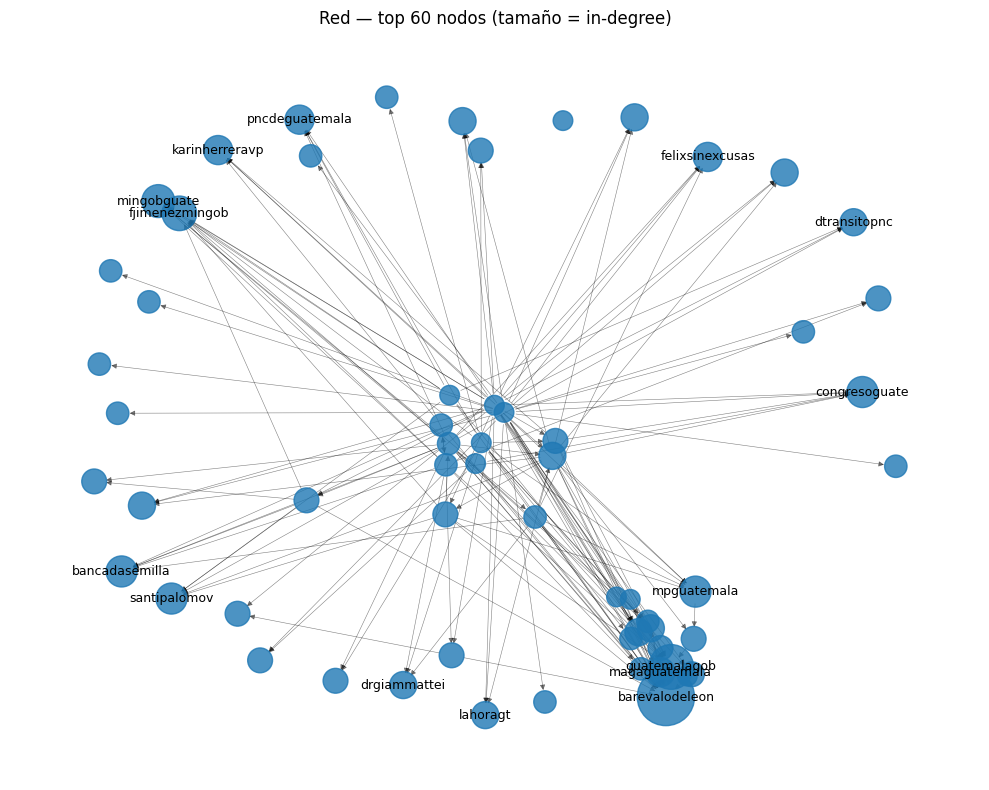

In [ ]:
# Construir el grafo con todas las interacciones
G = construir_grafo_dirigido(df_aristas)

# Rankings para identificar nodos más conectados/poder
ranks = rankings_basicos(G, k=15)
print("Top in-degree (más mencionados):\n", ranks['in_degree'])
print("\nTop out-degree (más activos):\n", ranks['out_degree'])
print("\nTop PageRank (influencia):\n", ranks['pagerank'])

# Visualización (mejor con un subgrafo de los más conectados)
Gtop = subgrafo_top(G, top_n=60)
dibujar_red(Gtop, k_labels=15, titulo="Red — top 60 nodos (tamaño = in-degree)")


5.2

In [23]:
def metricas_topologia(G: nx.DiGraph) -> dict:
    n, m = G.number_of_nodes(), G.number_of_edges()
    densidad = nx.density(G)  # m / (n*(n-1)) en grafos dirigidos

    # Diámetro: si el grafo no es conexo dirigido, usamos el mayor componente débil (undirected)
    if n <= 1 or m == 0:
        diametro = 0
    else:
        comp_weak = max(nx.weakly_connected_components(G), key=len)
        Gw = G.subgraph(comp_weak).to_undirected()
        diametro = nx.diameter(Gw) if Gw.number_of_nodes() > 1 else 0

    # Agrupamiento: promedio de clustering y/o transitivity (global clustering)
    G_u = G.to_undirected()
    clustering_prom = nx.average_clustering(G_u) if G_u.number_of_nodes() > 1 else 0.0
    transitivity   = nx.transitivity(G_u) if G_u.number_of_nodes() > 1 else 0.0

    return {
        "n_nodos": n,
        "n_aristas": m,
        "densidad": round(densidad, 5),
        "diametro_mayor_componente": int(diametro) if isinstance(diametro,(int,np.integer)) else diametro,
        "clustering_promedio": round(clustering_prom, 5),
        "transitividad": round(transitivity, 5),
    }

# Uso:
res = metricas_topologia(G)
for k, v in res.items():
    print(f"{k}: {v}")


n_nodos: 3134
n_aristas: 12464
densidad: 0.00127
diametro_mayor_componente: 6
clustering_promedio: 0.37341
transitividad: 0.0068
